# VGG16 model for classification of fruit and vegetables photos

Import libraries and download dataset

In [2]:
!pip install opendatasets
import opendatasets

opendatasets.download("https://www.kaggle.com/datasets/moltean/fruits")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wponie
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:08<00:00, 172MB/s]


Import other libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, load_model
from keras.optimizers import Adam
import tensorflow as tf
import cv2
from pathlib import Path
import os
import random


# Folders used for training / testing
fruits_and_vegetables = ["Apple Red 1", "Avocado", "Banana", "Blueberry", 
                         "Carambula", "Cauliflower", "Cocos", "Corn", 
                         "Eggplant", "Lemon", "Limes", "Lychee", "Onion Red", 
                         "Orange", "Pear", "Pepper Red", "Pineapple", 
                         "Raspberry", "Strawberry", "Watermelon"]

# Path to dataset
test_data_dir = Path(os.getcwd()) / "fruits" / "fruits-360_dataset" / "fruits-360" / "Test"
train_data_dir = Path(os.getcwd()) / "fruits" / "fruits-360_dataset" / "fruits-360" / "Training"

# Define size of input images
img_width, img_height = 100, 100

## Train model

In [ ]:
# Define number of classes
num_classes = len(fruits_and_vegetables)

# Create training set generator using augumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Create test set generator without augumentation, only normalizing
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate train data from dataset
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    classes=fruits_and_vegetables,
    class_mode='categorical')

# Generate test data from dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    classes=fruits_and_vegetables,
    class_mode='categorical')

# Load pretrained (on dataset "imagenet") VGG16 model excluding last layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create new model based on VGG16 and our classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze weights of convolutional layers of VGG16 model (only train classiication) 
for layer in base_model.layers:
    layer.trainable = False

# Compile prepared model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32)

# Save model to file 
model.save("model_vgg16.h5")

Found 9977 images belonging to 20 classes.
Found 3344 images belonging to 20 classes.
Epoch 1/10
311/311 [==============================] - 41s 128ms/step - loss: 1.6969 - accuracy: 0.5063 - val_loss: 0.6433 - val_accuracy: 0.9174
Epoch 2/10
311/311 [==============================] - 40s 130ms/step - loss: 0.5358 - accuracy: 0.8524 - val_loss: 0.3112 - val_accuracy: 0.9348
Epoch 3/10
311/311 [==============================] - 42s 136ms/step - loss: 0.2501 - accuracy: 0.9372 - val_loss: 0.2333 - val_accuracy: 0.9489
Epoch 4/10
311/311 [==============================] - 42s 134ms/step - loss: 0.1439 - accuracy: 0.9672 - val_loss: 0.1970 - val_accuracy: 0.9567
Epoch 5/10
311/311 [==============================] - 43s 138ms/step - loss: 0.0943 - accuracy: 0.9788 - val_loss: 0.1728 - val_accuracy: 0.9588
Epoch 6/10
311/311 [==============================] - 48s 154ms/step - loss: 0.0683 - accuracy: 0.9840 - val_loss: 0.1553 - val_accuracy: 0.9615
Epoch 7/10
311/311 [========================

## Load model from saved file

In [5]:
# Load model from file if you trained and saved before
model = load_model("model_vgg16.h5")

# Model summary


In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

# Test predictions

In [39]:
def predict_photo(file_path, n=3):
    """
    Predicts label of given photo. If file_name is None,
    random photo is chosen from folder_name directory

    Returns list of tuples of top n guesses.
    """

    img_path = test_data_dir / file_path
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    prediction = np.array(model(img, training=False))
    idxs = prediction.argsort()[0][::-1][:n]
    preds = [(fruits_and_vegetables[idx], prediction[0][idx]) for idx in idxs]
    return preds


def choose_random_file(folder_name):
    """
    Chooses random file from given folder and returns its name.
    """
    return random.choice(os.listdir(test_data_dir / folder_name))


def plot_predictions(folders=None):
    """ 
    Plots 6 predictions from given folders, 
    if folders are None, chooses them randomly
    """
    if folders is None:
        folders = random.sample(fruits_and_vegetables, 6)
    
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(14, 12)
    for i, folder in enumerate(folders):
        rand_file = choose_random_file(folder)
        preds = predict_photo(folder + '/' + rand_file)
        axs[i//3, i%3].imshow(plt.imread(test_data_dir / folder / rand_file))
        axs[i//3, i%3].set_title(f"Class: {folder}\n "
                                 f"{preds[0][0]}: {np.round(preds[0][1], 2)}%\n"
                                 f"{preds[1][0]}: {np.round(preds[1][1], 2)}%\n"
                                 f"{preds[2][0]}: {np.round(preds[2][1], 2)}%")

# Plot some random predictions

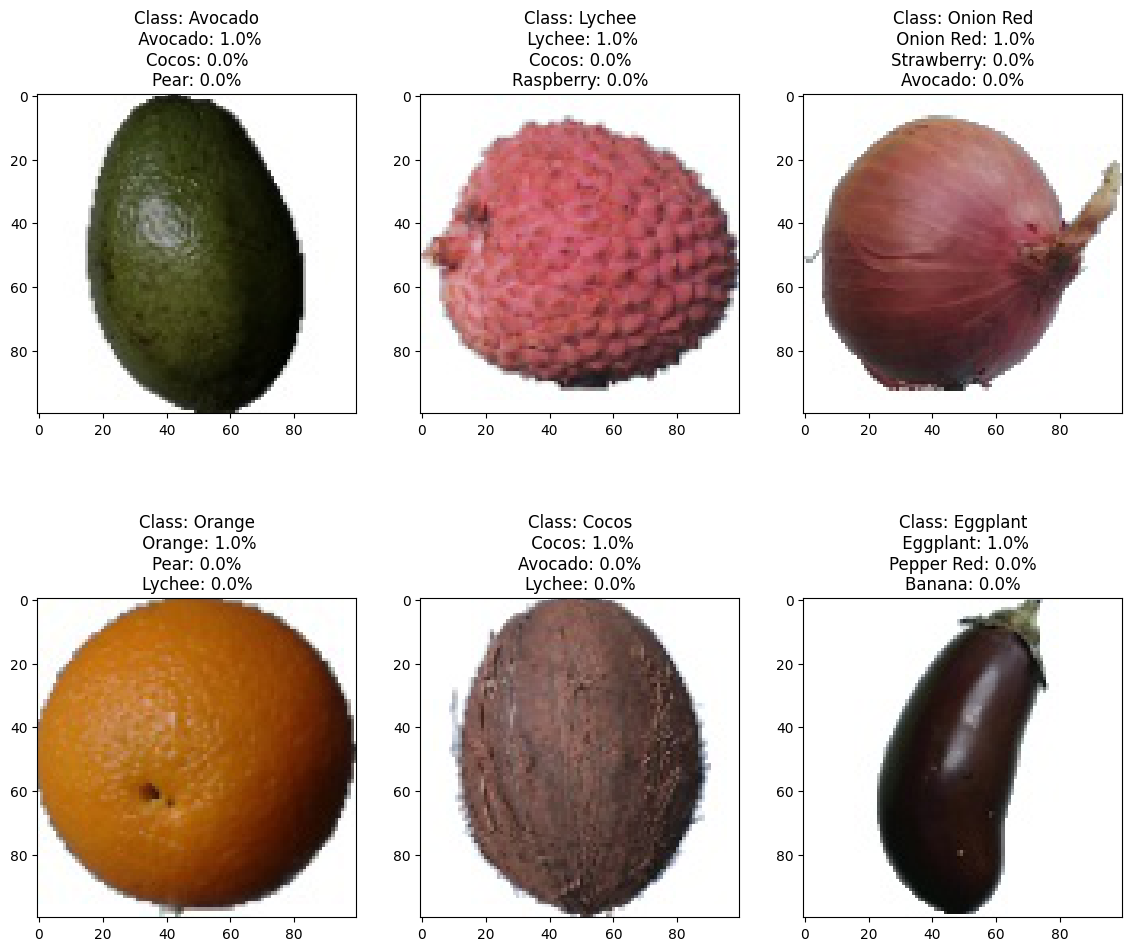

In [40]:
plot_predictions()

## GradCAM visualisation

In [41]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        
        raise ValueError("No 4D layers found!")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(inputs=[self.model.inputs],
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)

        return (heatmap, output)

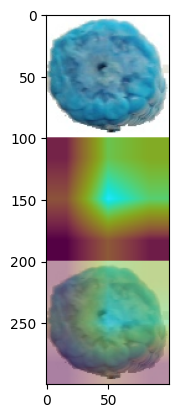

In [50]:
class_name = 'Corn'
class_idx = fruits_and_vegetables.index(class_name)
filename = choose_random_file(class_name)
imgpath = test_data_dir / class_name / filename

orig_img = cv2.imread(str(imgpath))

img = image.load_img(imgpath)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0
gradcam = GradCAM(model, class_idx)
heatmap = gradcam.compute_heatmap(img)

pred = predict_photo(imgpath)

heatmap = cv2.resize(heatmap, (img_width, img_height))
(heatmap, output) = gradcam.overlay_heatmap(heatmap, orig_img, alpha=0.5)

output = np.vstack([orig_img, heatmap, output])

plt.figure()
plt.imshow(output)

<br><br><br><br><br>
# Bibliography:
<br><br>
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models

<br><br>
https://towardsdatascience.com/visual-interpretability-for-convolutional-neural-networks-2453856210ce

<br><br>
https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
